# Light GBM Random Forest - Low Depth with Proper Encoding
As part of the overall stacking model, I will develop two Random Forest (RF) models: one with a relative low depth, and one with a high depth. I define low depth as `max_depth = 5` and high depth as `max_depth = 15`. With the depth defined, I tune the remaining parameters sequentially.  
  
In this notebook, I set out to optimise a **low depth RF model** using the LightGBM package. The optimisation sequence was as follows:  
  
1. No. of Trees (2,500)
2. RFECV (36)
3. Max Features (1/3 or 12)
4. Subsampling (0.90)
5. Min Samples in Leaf (10)
6. L1 Regularisation (0.6)
7. L2 Regularisation (0.1)
  
The final CV score was **83.02%**.

In [1]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
from lightgbm import LGBMClassifier
import kaggle_titanic as kt
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Prepare Data

In [2]:
# Import data
df = pd.read_csv('train.csv')

# Clean data
df = kt.clean_all(df)

# Encode data (only for RFECV purposes)
df_encoded, _ = kt.encode_train(df)

## Global Settings

In [3]:
# Create fold indices
folds = kt.get_folds(df=df, random_state=123)

# Get all datasets
all_sets = kt.prep_sets(df, folds)

## Iteration 1: Optimise No. of Trees

Computing test scores for n_estimators = 100...Done!
Computing test scores for n_estimators = 250...Done!
Computing test scores for n_estimators = 500...Done!
Computing test scores for n_estimators = 1000...Done!
Computing test scores for n_estimators = 1500...Done!
Computing test scores for n_estimators = 2000...Done!
Computing test scores for n_estimators = 2500...Done!
Computing test scores for n_estimators = 3000...Done!
Computing test scores for n_estimators = 4000...Done!
Computing test scores for n_estimators = 5000...Done!
Computing test scores for n_estimators = 6000...Done!


[ RESULTS ]
   Best Score: 0.824904200210867
Optimal Value: 250


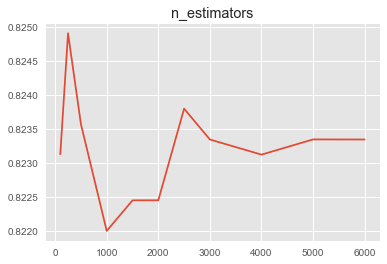

In [4]:
# Define parameters
param_n_estimators = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000]
params = {
    'n_estimators': param_n_estimators
}

# Grid Search with CV
cv_res, best_n_estimators = kt.score_grid(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample_freq = 1,
        max_depth = 5,
        # n_estimators = ,
        colsample_bytree = 0.5,
        subsample = 0.75,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    params = params,
    all_sets = all_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 2: RFECV for Feature Selection

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 33.0min finished


   Best Score: 0.8244610674494207
Optimal Value: 36


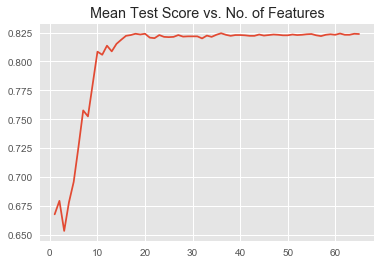

In [5]:
# Run RFECV
cv_res, best_n_features, opt_feats = kt.custom_rfecv(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 0.5,
        subsample = 0.75,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    sub_sets = all_sets,
    df = df_encoded,
    step = 1,
    n_jobs = 3,
    verbose = True
)

### Subset Features

In [4]:
# Set features
final_feats = [
    'pclass_OC', 'sex_BN', 'age_OC', 'age_NM', 'sibsp_NM', 'sibsp_OC', 'parch_NM', 'parch_OC',
    'fare_NM', 'fare_OC', 'pclass_ME', 'title_ME', 'age_ME', 'sibsp_ME', 'ticlen_ME', 'fare_ME', 'cabletter_ME',
    'cabno_ME', 'embarked_ME', 'pclass_OH_CLASS3', 'title_OH_Master.', 'title_OH_Miss.', 'title_OH_Mr.',
    'sex_OH_female', 'age_OH_A6', 'sibsp_OH_None', 'ticlen_OH_L4', 'ticlen_OH_L5', 'ticlen_OH_L6', 'ticlen_OH_LO',
    'fare_OH_G4', 'cabletter_OH_B/D/E', 'cabletter_OH_Others', 'cabno_OH_C1', 'cabno_OH_NIL', 'embarked_OH_S'
]

# Separate features
# final_feats = list(opt_feats)
print(final_feats)

['pclass_OC', 'sex_BN', 'age_OC', 'age_NM', 'sibsp_NM', 'sibsp_OC', 'parch_NM', 'parch_OC', 'fare_NM', 'fare_OC', 'pclass_ME', 'title_ME', 'age_ME', 'sibsp_ME', 'ticlen_ME', 'fare_ME', 'cabletter_ME', 'cabno_ME', 'embarked_ME', 'pclass_OH_CLASS3', 'title_OH_Master.', 'title_OH_Miss.', 'title_OH_Mr.', 'sex_OH_female', 'age_OH_A6', 'sibsp_OH_None', 'ticlen_OH_L4', 'ticlen_OH_L5', 'ticlen_OH_L6', 'ticlen_OH_LO', 'fare_OH_G4', 'cabletter_OH_B/D/E', 'cabletter_OH_Others', 'cabno_OH_C1', 'cabno_OH_NIL', 'embarked_OH_S']


In [5]:
# Re-generate sets
new_sets = kt.prep_sets(df = df, folds = folds, feats = final_feats)

## Iteration 3: Tune Maximum Features

In [8]:
# Get max features
n_feat = np.min([new_sets[i][0].shape[1] for i in range(len(new_sets))])

Computing test scores for colsample_bytree = 0.05555555555555555...Done!
Computing test scores for colsample_bytree = 0.08333333333333333...Done!
Computing test scores for colsample_bytree = 0.1111111111111111...Done!
Computing test scores for colsample_bytree = 0.1388888888888889...Done!
Computing test scores for colsample_bytree = 0.16666666666666666...Done!
Computing test scores for colsample_bytree = 0.19444444444444445...Done!
Computing test scores for colsample_bytree = 0.2222222222222222...Done!
Computing test scores for colsample_bytree = 0.24999999999999997...Done!
Computing test scores for colsample_bytree = 0.2777777777777778...Done!
Computing test scores for colsample_bytree = 0.3055555555555556...Done!
Computing test scores for colsample_bytree = 0.33333333333333337...Done!
Computing test scores for colsample_bytree = 0.36111111111111105...Done!
Computing test scores for colsample_bytree = 0.38888888888888884...Done!
Computing test scores for colsample_bytree = 0.416666666

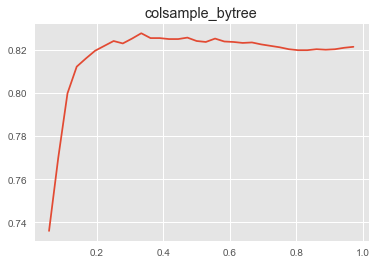

In [10]:
# Define parameters
param_max_feat = np.arange(2/n_feat, 1, 1/n_feat)
params = {
    'colsample_bytree': param_max_feat
}

# Grid Search with CV
cv_res, best_colsample_bytree = kt.score_grid(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 0.5,
        subsample = 0.75,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

In [15]:
print(best_colsample_bytree)

0.33333333333333337


## Iteration 4: Tune Subsampling Proportion

Computing test scores for subsample = 0.3...Done!
Computing test scores for subsample = 0.4...Done!
Computing test scores for subsample = 0.5...Done!
Computing test scores for subsample = 0.6...Done!
Computing test scores for subsample = 0.7...Done!
Computing test scores for subsample = 0.8...Done!
Computing test scores for subsample = 0.9...Done!
Computing test scores for subsample = 0.99...Done!


[ RESULTS ]
   Best Score: 0.8296169533372557
Optimal Value: 0.99


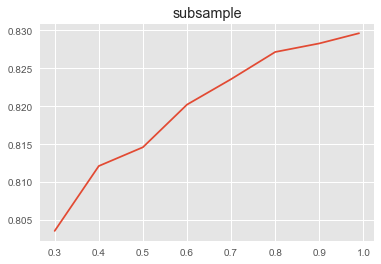

In [16]:
# Define parameters
param_subsample = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
params = {
    'subsample': param_subsample
}

# Grid Search with CV
cv_res, best_subsample = kt.score_grid(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 1/3,
        # subsample = 0.75,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 5: Tune Min. Samples in Leaf

Computing test scores for min_child_samples = 1...Done!
Computing test scores for min_child_samples = 5...Done!
Computing test scores for min_child_samples = 10...Done!
Computing test scores for min_child_samples = 20...Done!
Computing test scores for min_child_samples = 30...Done!
Computing test scores for min_child_samples = 40...Done!
Computing test scores for min_child_samples = 50...Done!


[ RESULTS ]
   Best Score: 0.8311912566445624
Optimal Value: 1


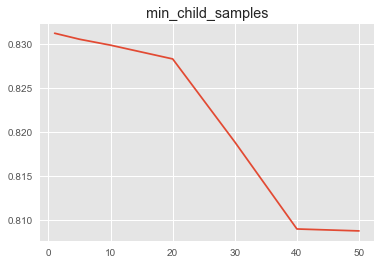

In [17]:
# Define parameters
param_min_leaf = [1,5,10,20,30,40,50]
params = {
    'min_child_samples': param_min_leaf
}

# Grid Search with CV
cv_res, best_min_leaf = kt.score_grid(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 1/3,
        subsample = 0.9,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 6: Tune L1 Regularisation (Alpha)

Computing test scores for reg_alpha = 0...Done!
Computing test scores for reg_alpha = 0.1...Done!
Computing test scores for reg_alpha = 0.2...Done!
Computing test scores for reg_alpha = 0.3...Done!
Computing test scores for reg_alpha = 0.4...Done!
Computing test scores for reg_alpha = 0.5...Done!
Computing test scores for reg_alpha = 0.6...Done!
Computing test scores for reg_alpha = 0.7...Done!
Computing test scores for reg_alpha = 0.8...Done!
Computing test scores for reg_alpha = 0.9...Done!


[ RESULTS ]
   Best Score: 0.8302847910143568
Optimal Value: 0.6


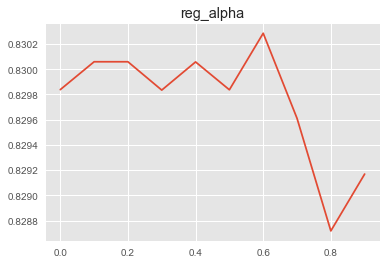

In [18]:
# Define parameters
param_alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_alpha': param_alpha
}

# Grid Search with CV
cv_res, best_alpha = kt.score_grid(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 1/3,
        subsample = 0.9,
        min_child_samples = 10,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 7: Tune L2 Regularisation (Lambda)

Computing test scores for reg_lambda = 0...Done!
Computing test scores for reg_lambda = 0.1...Done!
Computing test scores for reg_lambda = 0.2...Done!
Computing test scores for reg_lambda = 0.3...Done!
Computing test scores for reg_lambda = 0.4...Done!
Computing test scores for reg_lambda = 0.5...Done!
Computing test scores for reg_lambda = 0.6...Done!
Computing test scores for reg_lambda = 0.7...Done!
Computing test scores for reg_lambda = 0.8...Done!
Computing test scores for reg_lambda = 0.9...Done!


[ RESULTS ]
   Best Score: 0.8302860464283296
Optimal Value: 0.1


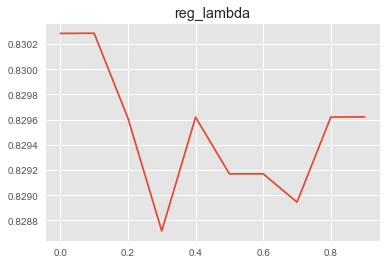

In [19]:
# Define parameters
param_lambda = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_lambda': param_lambda
}

# Grid Search with CV
cv_res, best_lambda = kt.score_grid(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 1/3,
        subsample = 0.9,
        min_child_samples = 10,
        reg_alpha = 0.6,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)